# Custom design of experiments (custom DOE)
Reference:    https://datachemeng.com/designofexperimentscodes/

In [1]:
import numpy as np
import pandas as pd
from numpy import matlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

%matplotlib inline

C:\Users\mmm\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Determine variables

In [2]:
# Experiment conditions
variables = {'var_1': [100.0, 150.0, 200.0],        # process 1 temperature  (example)
             'var_2': [1.0, 2.0, 3.0],              # process 1 time         (example)
             'var_3': [300.0, 350.0, 400.0],        # process 2 temperature  (example)
             'var_4': [2.0, 2.5, 3.0],              # process 2 time         (example)
             'var_5': [200.0, 225.0, 250.0],        # process 3 temperature  (example)
             }

In [3]:
# Make experiment condition dictionary for future use
val_name = variables.keys()
process_name = ['temp_1', 'time_1', 'temp_2', 'time_2', 'cooling_rate', 'additive']
process_cond = dict(zip(val_name, process_name))
process_cond

{'var_1': 'temp_1',
 'var_2': 'time_1',
 'var_3': 'temp_2',
 'var_4': 'time_2',
 'var_5': 'cooling_rate'}

### Make all possible experiments for later random search

In [4]:
all_experiments = list(itertools.product(variables['var_1'], variables['var_2'], variables['var_3'],
                                         variables['var_4'], variables['var_5']))

print('Number of all possible combinations = ', len(all_experiments))

Number of all possible combinations =  243


In [5]:
# Convert to DataFrame for future use
all_experiments_df = pd.DataFrame(all_experiments)
all_experiments_df.columns = process_cond.values()

print('Shape of the DataFrame', all_experiments_df.shape)
all_experiments_df.head()

Shape of the DataFrame (243, 5)


,temp_1,time_1,temp_2,time_2,cooling_rate
0,100.0,1.0,300.0,2.0,200.0
1,100.0,1.0,300.0,2.0,225.0
2,100.0,1.0,300.0,2.0,250.0
3,100.0,1.0,300.0,2.5,200.0
4,100.0,1.0,300.0,2.5,225.0


Now, preparation for experiment data is done.
### DOE

In [6]:
# DOE preparation
np.random.seed(111)                                     # fix random seed
experiment_index = np.arange(len(all_experiments_df))
number_of_random_searches = 10000                       # iteration to find better combinations
number_of_experiments = 12                              # number of experiments that can be conducted

In [7]:
# Standardization function
def auto_scale(data_frame):
    autoscaled_all_experiments = (data_frame - data_frame.mean(axis=0)) / data_frame.std(axis=0)
    return np.array(autoscaled_all_experiments)

### DOE optimal type = [1] Maximize determinant of dot product (X.T, X)

In [8]:
#del(best_optimal_monitor, timing_of_best)

best_optimal_monitor = []
timing_of_best = []

In [9]:
for random_search_number in range(number_of_random_searches):
    new_selected_experiment_numbers = np.random.randint(0, len(all_experiments_df), number_of_experiments)
    new_selected_experiments = all_experiments_df.loc[new_selected_experiment_numbers]
    autoscaled_new_selected_experiments = auto_scale(new_selected_experiments)
    X = autoscaled_new_selected_experiments
    
    optimal_value = np.linalg.det(np.dot(X.T, X))
               
    if random_search_number == 0:
        best_optimal_value = optimal_value
        selected_experiment_indexes = new_selected_experiment_numbers.copy()
        
    if best_optimal_value < optimal_value:
        best_optimal_value = optimal_value
        selected_experiment_indexes = new_selected_experiment_numbers.copy()
        print(random_search_number, '\t', best_optimal_value)
        
        best_optimal_monitor.append(best_optimal_value)
        timing_of_best.append(random_search_number)
        
    continue

final_selected_experiments = all_experiments_df.loc[selected_experiment_indexes]

6 	 101386.48157543392
58 	 130049.02574595046
837 	 132847.89061162926
1926 	 138738.65116470438
2934 	 140516.21061271484
6598 	 143910.53947174762
7074 	 144284.41247804856
7788 	 144713.6571420245


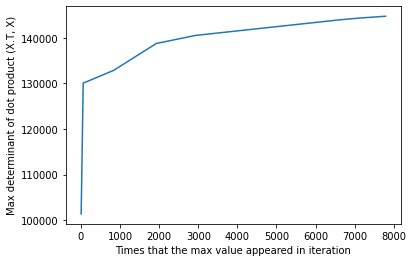

In [10]:
plt.plot(timing_of_best, best_optimal_monitor)
plt.xlabel('Times that the max value appeared in iteration')
plt.ylabel('Max determinant of dot product (X.T, X)')
plt.show()

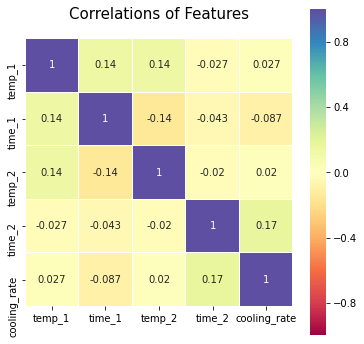

In [11]:
colormap = 'Spectral'
plt.figure(figsize=(6, 6))
plt.title('Correlations of Features', y=1.05, size=15)
sns.heatmap(final_selected_experiments.astype(float).corr(), linewidths = 0.1, vmax = 1.0, vmin = -1.0,
            square=True, cmap=colormap, linecolor='white', annot = True)
plt.ylim(final_selected_experiments.astype(float).corr().shape[0], 0)
plt.show()

In [12]:
x = np.corrcoef(final_selected_experiments.transpose()).flatten()
final_selected_experiments.to_csv('final_selected_experiments_type[1].csv')
corr = [-1.0 if i > 0.95 else np.abs(i) for i in x]
np.max(corr)

0.17391304347826086

### DOE optimal type = [2] Minimize sum of diagonal of inverse matrix of dot product (X.T, X)

In [13]:
del best_optimal_monitor, timing_of_best

best_optimal_monitor = []
timing_of_best = []

In [14]:
for random_search_number in range(number_of_random_searches):
    new_selected_experiment_numbers = np.random.randint(0, len(all_experiments_df), number_of_experiments)
    new_selected_experiments = all_experiments_df.loc[new_selected_experiment_numbers]
    autoscaled_new_selected_experiments = auto_scale(new_selected_experiments)
    X = autoscaled_new_selected_experiments
    
    optimal_value = np.sum(np.trace(np.linalg.inv(np.dot(X.T, X))))
               
    if random_search_number == 0:
        best_optimal_value = optimal_value
        selected_experiment_indexes = new_selected_experiment_numbers.copy()
        
    if best_optimal_value > optimal_value:
        best_optimal_value = optimal_value
        selected_experiment_indexes = new_selected_experiment_numbers.copy()
        print(random_search_number, '\t', best_optimal_value)
        
        best_optimal_monitor.append(best_optimal_value)
        timing_of_best.append(random_search_number)
        
    continue
    
final_selected_experiments = all_experiments_df.loc[selected_experiment_indexes]

5 	 0.5764413199794556
9 	 0.5646017610214528
13 	 0.5541748930374524
23 	 0.5453229975438891
39 	 0.49055606772648574
931 	 0.4822572320873702
1527 	 0.47316947091562617


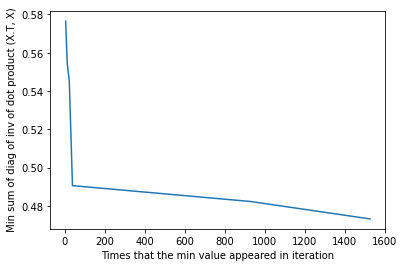

In [15]:
plt.plot(timing_of_best, best_optimal_monitor)
plt.xlabel('Times that the min value appeared in iteration')
plt.ylabel(' Min sum of diag of inv of dot product (X.T, X)')
plt.show()

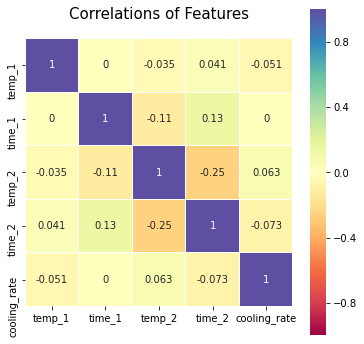

In [16]:
colormap = 'Spectral'
plt.figure(figsize=(6, 6))
plt.title('Correlations of Features', y=1.05, size=15)
sns.heatmap(final_selected_experiments.astype(float).corr(), linewidths = 0.1, vmax = 1.0, vmin = -1.0,
            square=True, cmap=colormap, linecolor='white', annot = True)
plt.ylim(final_selected_experiments.astype(float).corr().shape[0], 0)
plt.show()

In [17]:
x = np.corrcoef(final_selected_experiments.transpose()).flatten()
final_selected_experiments.to_csv('final_selected_experiments_type[2].csv')
corr = [-1.0 if i > 0.95 else np.abs(i) for i in x]
np.max(corr)

0.2528608687120869

### Check counting the same raws between [1] and [2]

In [18]:
final_1 = pd.read_csv('final_selected_experiments_type[1].csv')
final_2 = pd.read_csv('final_selected_experiments_type[2].csv')

df_same = pd.merge(final_1.iloc[:, 1:7], final_2.iloc[:, 1:7], how = 'inner')
print('The identical raws')
df_same

The identical raws


,temp_1,time_1,temp_2,time_2,cooling_rate
0,150.0,3.0,350.0,3.0,225.0


## APPENDIX - comparison with orthogonal array and other optimal types

In [19]:
# See correlations in L18 orthogonal array for example
orthogonal = pd.read_csv('L18_example.csv')
orthogonal = orthogonal.iloc[:, 1:9]
orthogonal.head()

,Factor-1,Factor-2,Factor-3,Factor-4,Factor-5,Factor-6,Factor-7,Factor-8
0,1,1,1,1,1,1,1,1
1,1,1,2,2,2,2,2,2
2,1,1,3,3,3,3,3,3
3,1,2,1,1,2,2,3,3
4,1,2,2,2,3,3,1,1


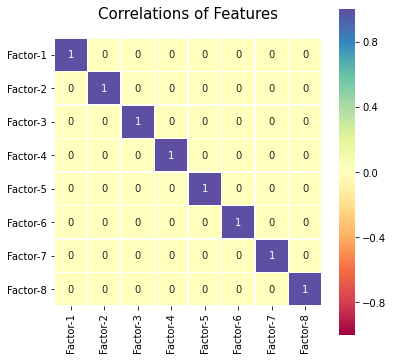

In [20]:
colormap = 'Spectral'
plt.figure(figsize=(6, 6))
plt.title('Correlations of Features', y=1.05, size=15)
sns.heatmap(orthogonal.astype(float).corr(), linewidths = 0.1, vmax = 1.0, vmin = -1.0,
            square=True, cmap=colormap, linecolor='white', annot = True)
plt.ylim(orthogonal.astype(float).corr().shape[0], 0)
plt.show()

### DOE optimal type = [3] Maximize minimum value of eigenvalue of dot product (X.T, X)

In [21]:
del best_optimal_monitor, timing_of_best

best_optimal_monitor = []
timing_of_best = []

In [22]:
for random_search_number in range(number_of_random_searches):
    new_selected_experiment_numbers = np.random.randint(0, len(all_experiments_df), number_of_experiments)
    new_selected_experiments = all_experiments_df.loc[new_selected_experiment_numbers]
    autoscaled_new_selected_experiments = auto_scale(new_selected_experiments)
    X = autoscaled_new_selected_experiments
    
    w, v = np.linalg.eig(np.dot(X.T, X))
    optimal_value = np.min(w)
               
    if random_search_number == 0:
        best_optimal_value = optimal_value
        selected_experiment_indexes = new_selected_experiment_numbers.copy()
        
    if best_optimal_value < optimal_value:
        best_optimal_value = optimal_value
        selected_experiment_indexes = new_selected_experiment_numbers.copy()
        print(random_search_number, '\t', best_optimal_value)
        
        best_optimal_monitor.append(best_optimal_value)
        timing_of_best.append(random_search_number)
        
    continue
    
final_selected_experiments = all_experiments_df.loc[selected_experiment_indexes]

1 	 3.0081010588269947
2 	 3.104444446060319
3 	 5.074669279137422
8 	 5.160703721503605
61 	 7.201133405129905
245 	 7.917682946450889
6295 	 8.186056027257973


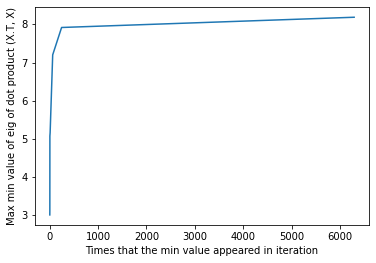

In [23]:
plt.plot(timing_of_best, best_optimal_monitor)
plt.xlabel('Times that the min value appeared in iteration')
plt.ylabel('Max min value of eig of dot product (X.T, X)')
plt.show()

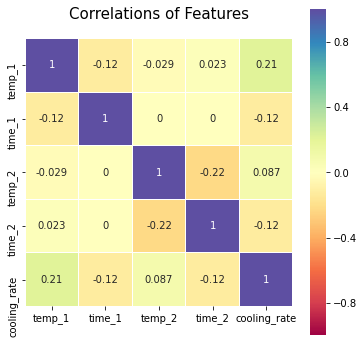

In [24]:
colormap = 'Spectral'
plt.figure(figsize=(6, 6))
plt.title('Correlations of Features', y=1.05, size=15)
sns.heatmap(final_selected_experiments.astype(float).corr(), linewidths = 0.1, vmax = 1.0, vmin = -1.0,
            square=True, cmap=colormap, linecolor='white', annot = True)
plt.ylim(final_selected_experiments.astype(float).corr().shape[0], 0)
plt.show()

In [25]:
x = np.corrcoef(final_selected_experiments.transpose()).flatten()
corr = [-1.0 if i > 0.95 else np.abs(i) for i in x]
np.max(corr)

0.21938172723813926